# 尝试使用K-Means聚类和HMM模型来解决蜘蛛网问题

## 结合价格序列数据和龙虎榜数据

因为要同时观察的量比较多，所以直接从各个维度划分类别变得比较不可行，这里使用k-means先进性聚类，将市场状态进行划分。k-means需要指定类别的参数，这也整个模型非常重要的一个参数。

这个版本同时使用龙虎榜信息和价格序列。龙虎榜是蜘蛛网策略的初衷，同时由于决定采用隐马尔可夫模型，而这个模型的精髓在于处理时序数据，所以这里加入价格序列信息的使用。方法是取每天固定几个点的价格，使用k-means聚类，力图发现日内价格的某种模式，然后，也是和以前一样，使用离散观察值的HMM算法。

然后我们尝试使用hmmlearn来进行一次隐马尔可夫模型的尝试。具体做法是，输入之前聚类后的观察值的序列，然后使用传统的维特比算法计算最大可能性的隐状态链。然后将隐状态和当天的收益率联系起来，具体做法是，分别对每一种状态的当日收益率进行累乘，计算复利，相当于满仓做多。然后将不同隐状态满仓做多的表现呈现在一个图上。

这样我们得到了每一个隐状态的表现，并且我们知道哪一个隐状态适合做多，哪一个适合做空，然后我们预测下一个隐状态，并采取相应的操作。

同时也应该看到，使用增幅数据比使用比重更有效。因为变化幅度更能描述市场的动态。

## 文件头和引用

In [51]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
from sklearn import cluster
from hmmlearn import hmm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import copy
from sklearn import preprocessing
import datetime

## 设定参数并启动

> * `FutureList`需要实验的品种列表，总共有'ag', 'au', 'cu', 'i', 'IF','j', 'jm', 'm', 'rb', 'ru'可以选择，其中i和jm的数据是从2014年开始的，共1054条记录，其余的是从2013年开始的，共1292条记录。
> * `PricePointNum`日内价格取多少个观测点（不包括开盘价和收盘价）至少为1
> * `LabelNum`聚类的组数
> * `HiddenStateNum`隐状态数量
> * `Columns`用于聚类的特征，可取的特征有：交易日,合约,开盘价,收盘价,日涨幅,最高价,最低价,日振幅,合约成交量,合约持仓量,多头持仓,多头增仓,多头增幅,多头比重,空头持仓,空头增仓,空头增幅,空头比重,成交量现量,成交量变化,成交量增幅,成交量比重。
> * `TestSize`测试集的长度。此处定义为长度而非比例主要是为了后续品种之间的性能对比，而且我们已经知道记录的总长度，通过测试集长度也可以确定其比例。
> * `RankWeight`期货龙虎榜计算得来的交易信号的权重
> * `PatternWeight`日内价格模式计算得来的交易信号的权重

In [52]:
Columns = ['日涨幅','日振幅','多头增幅','空头增幅','成交量增幅']

#FutureList = ['ag', 'au', 'cu', 'i', 'IF','j', 'jm', 'm', 'rb', 'ru']
#FutureList = ['ag', 'au', 'cu', 'IF','j', 'm', 'rb', 'ru']
#FutureList = ['i', 'jm']
FutureList = ['cu', 'IF']

TestSize = 500

PricePointNum = 16 #日内价格取多少个观测点（不包括开盘价和收盘价）至少为1
#PricePointNumRange = [2, 4, 8, 16]
PricePointNumRange = [16]

LabelNum = 20 #聚类的组数
#LabelNumRange = [10, 15, 20, 25, 30]
LabelNumRange = [30]

HiddenStateNum = 5 #隐状态数量
HiddenStateNumRange = [4, 6, 8]

RankWeight = 0.6 #龙虎榜信号在交易中的比重
RankWeightRange = [0.2, 0.4, 0.6, 0.8]

PatternWeight = 1.0 - RankWeight #价格走势信号在交易中的比重

## 载入龙虎榜和价格数据

读入龙虎榜累加数据和价格并返回二维数组格式。为了保证状态链不断开，这里直接在时间顺序上分为训练集和测试集。龙虎榜数据用于聚类和预测，价格数据用于计算收益率。

> 参数
> * `filename`文件名
> * `columns`需要取的列
> * `testsize`测试集大小

> 返回
> * `data[:trainlen]`特征数据训练集
> * `price[:trainlen]`价格日涨幅训练集
> * `data[trainlen:]`特征数据测试集
> * `price[trainlen:]`价格日涨幅测试集

In [53]:
def load_rank_price_data(future, columns, testsize):
    table = pd.read_csv(future + '_rank_sum.csv')
    data = table[columns].values
    price = table['日涨幅'].values
    return data[:-testsize], price[:-testsize], data[-testsize:], price[-testsize:]

## 载入日内价格走势数据

读入min_price和min_volume两个文件，分别是日内分钟收盘价和日内分钟交易量。在日内选取n个观测点，则将日内数据均分为n份，计算n个加权平均价，然后将昨收价，开盘价，n个观测价，收盘价排成一个序列，依次计算第i+1个价格相对于第i个价格的涨幅，最终形成的tuple的长度是n+2。

> 参数
> * `future`期货品种
> * `pricepointnum`价格观测点的数量（不包含开盘价和收盘价），至少为1
> * `testsize`测试集长度

> 返回
> * `pattern[:-testsize]`价格走势训练集
> * `pattern[-testsize:]`价格走势测试集

In [54]:
def load_price_pattern_data(future, pricepointnum, testsize):
    pricedata = pd.read_csv(future + '_min_price.csv')
    volumedata = pd.read_csv(future + '_min_volume.csv')
    table = pd.read_csv(future + '_rank_sum.csv')
    if len(table.index) != len(pricedata.columns) or len(table.index) != len(volumedata.columns):
        print(future + ' Bad Data Length!')
    
    length = len(pricedata.columns)
    pattern = np.zeros((length, pricepointnum + 2))
                       
    for i in range(length):
        tabletradedate = ''.join(table['交易日'][i].split('-'))
        if tabletradedate != pricedata.columns[i] or tabletradedate != volumedata.columns[i]:
            print(future + ' Bad Trade Date!')
            print(table['交易日'][i].strip().strip('-') + ', ' + pricedata.columns[i] + ', ' + volumedata.columns[i])
        tradedate = pricedata.columns[i]
        pricelist = np.array(pricedata[tradedate].dropna())
        volumelist = np.array(volumedata[tradedate].dropna())
        if len(pricelist) != len(volumelist):
            print('Bad Volume Length!')
        
        #将价格序列分成pricepointnum段
        steplen = float(len(pricelist)) / float(pricepointnum)
        checklist = []
        for j in range(pricepointnum):
            checklist.append(min(len(pricelist) - 1, int(round(steplen * (j + 1)))))
        
        pvsum = 0.0
        vsum = 0.0
        intradayprice = [table['昨收价'][i], table['开盘价'][i]]
        for j in range(len(pricelist)):
            #成交量这里加上1防止全是0的话会在求加权价的时候产生除零错误
            pvsum += pricelist[j] * (volumelist[j] + 1.0)
            vsum += (volumelist[j] + 1.0)
            if j in checklist:
                if vsum == 0:
                    print('Bad 0!')
                intradayprice.append(pvsum / vsum)
                pvsum = 0.0
                vsum = 0.0
        intradayprice.append(table['收盘价'][i])
        
        for j in range(pricepointnum + 2):
            pattern[i, j] = (intradayprice[j + 1] - intradayprice[j]) / intradayprice[j]
    #print(pattern[:-testsize])
    #print(pattern[-testsize:])
    return pattern[:-testsize], pattern[-testsize:]

## 正则化聚类函数

使用sklearn进行正则化，然后调用sklearn中的k-means算法聚类

> 参数
> * `data`需要聚类的数据
> * `num`聚类的类数

> 返回
> * `labels`每个数据点的类别标记，是从零开始的自然数。以列表形式返回，长度等于输入数据的条数。

sklearn的k-means运用了Lioyd's算法。http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

> 时间复杂度
> * 平均计算复杂度是`O(k n T)`，其中n是样本量，T是迭代次数。
> * 计算复杂读在最坏的情况下为`O(n^(k+2/p))`，其中n是样本量，p是特征个数。(D. Arthur and S. Vassilvitskii, ‘How slow is the k-means method?’ SoCG2006）

> 参数解释
> * `n_clusters`要聚类的类的数量
> * `n_init`总共尝试的次数（算法在有限次内给出最优解）
> * `max_iter`最大迭代次数（如果不收敛的话）
> * `tol`收敛条件。这里要涉及一个属性叫做`inertia_`是所有点到它的质心的距离之和。如果两次迭代的`inertia_`的差小于`tol`，则说明k-means算法已经收敛，这时算法停止。

In [55]:
def normalise_cluster(data, num):
    datanormal = copy.deepcopy(data)
    scaler = preprocessing.QuantileTransformer(output_distribution='normal')
    scaler = scaler.fit(datanormal)
    datanormal = scaler.transform(datanormal)
    model = cluster.KMeans(n_clusters=num, n_init = 10, max_iter = 300, tol = 0.00001).fit(datanormal)
    labels  = model.predict(datanormal)
    return labels

## 离散的隐马尔可夫模型函数

k-means函数之后得到了一个类别序列，我们将它作为观察值序列输入隐马尔可夫模型，得到隐状态的链

> 参数
> * `obseq`观察值序列
> * `num`隐状态数量

> 返回
> * `state_sequence`使用维特比算法（Viterbi algorithm）计算的最大概率的隐状态序列
> * `model`隐马尔可夫模型本身用于后续的计算

hmmlearn的MultinomialHMM默认使用维特比算法进行解码。http://hmmlearn.readthedocs.io/en/latest/api.html#multinomialhmm

> 参数解释
> * `n_components`隐状态数量
> * `n_iter`最大迭代执行次数
> * `tol`收敛阈值。如果对数似然的增益低于此值，EM将停止。鲍姆-韦尔奇算法（Baum–Welch algorithm）就是寻找一组隐马尔可夫模型的参数，使得在给定参数构成的隐马尔可夫模型中，观察序列出现的概率最大。这一过程实际上就是在最大似然估计，对数似然就是这一概率的对数。当这一概率的增长已经非常小，低于某个阈值的时候，说明模型已经收敛，这时算法停止。

In [56]:
def hmm_multinomial(obseq, num):
    model = hmm.MultinomialHMM(n_components = num, n_iter=10, tol=0.001).fit(obseq)
    if not model.monitor_.converged:
        print(u'Not Converged!')
    state_sequence = model.predict(obseq)
    return state_sequence, model

## 多折线图绘图

> 参数
> * `data`需要作图的数据（N，L），共N条线，每条线长度L个数据
> * `plotlabels`标签（N），对应每一条线的名字
> * `x_name`X轴名字
> * `y_name`Y轴名字
> * `title`标题

> 作图
> * 多折线图

In [57]:
def multi_plot(data, plotlabels, x_name, y_name, title):
    if not (len(data) == len(plotlabels)):
        print(u'Bad Plot Length!')
        return
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (16, 9))
    for i in range(len(data)):
        axs.plot(range(len(data[i].T)), data[i].T, label = plotlabels[i])
    plt.legend()
    axs.set_xlabel(x_name)
    axs.set_ylabel(y_name)
    axs.set_title(title)
    plt.show()

## 将隐状态对应到涨跌

我们获得隐状态序列后，还需要对隐状态进行解释，这里我们将其与当日的涨跌对应起来。具体的做法是，分别假设在某个状态当日单独做多或者做空，分别计算净值并返回。

> 参数
> * `future`期货品种
> * `price`从文件中取回的价格序列
> * `state_sequence`隐状态序列
> * `num`隐状态序列
> * `showplot`是否显示图片

> 返回
> * `state_long`（N，L）的矩阵，N个隐状态，L个交易日，表示各个隐状态在L个交易日中单纯做多的净值表现
> * `state_short`（N，L）的矩阵，N个隐状态，L个交易日，表示各个隐状态在L个交易日中单纯做空的净值表现

> 绘图
> * 对于每一个隐状态i，假设当某一日计算结果为隐状态i的时候，满仓做多这一期货品种，得到净值累计曲线。
> * 对于每一个隐状态i，假设当某一日计算结果为隐状态i的时候，满仓做空这一期货品种，得到净值累计曲线。

In [58]:
def state_to_value(future, price, state_sequence, num):
    state_long = np.zeros((num, len(state_sequence) + 1))
    state_short = np.zeros((num, len(state_sequence) + 1))
    #开始的净值是1.0
    for i in range(num):
        state_long[i, 0] = 1.0
        state_short[i, 0] = 1.0
    
    for i in range(len(state_sequence)):
        for j in range(num):
            state_long[j, i + 1] = state_long[j, i]
            state_short[j, i + 1] = state_short[j, i]
            if state_sequence[i] == j:
                state_long[j, i + 1] *= (1.0 + price[i])
                state_short[j, i + 1] *= (1.0 - price[i])
    return state_long, state_short

## 找出夏普最大的隐状态

分别对隐状态的净值表现计算夏普率，返回夏普率最大的隐状态。

计算夏普比率的时候，无风险年化收益率取0.04，对标十年期国债利率，每年交易日我们认为是252。

> 参数
> * `state_value`（N，L）N个隐状态在L个交易日中的净值

> 返回
> * `best_state`夏普最高的那个隐状态

In [59]:
def max_sharpe_state(state_value):
    best_state = 0
    max_sharpe = 0
    for i in range(len(state_value)):
        values = copy.deepcopy(state_value[i].T)
        returns = []
        for j in range(1, len(values)):
            returns.append((values[j] - values[j - 1]) / values[j - 1] - 0.04 / 252)    
        #计算年化夏普，无风险年化收益率取0.04，对标十年期国债利率，每年交易日认为是252个
        annualised_sharpe = np.sqrt(252) * np.mean(returns) / np.std(returns)
        if annualised_sharpe > max_sharpe:
            best_state = i
            max_sharpe = annualised_sharpe
    return best_state

## 净值序列转化为交易信号

我们从各个隐状态分别做多和做空所得到的净值表格中，计算出最适合做多和做空的隐状态，我们命名为best_long和best_short，当预测下一个隐状态为best_long时，我们返回做多信号（+1），为best_short时，我们返回做空信号（-1）。

> 参数
> * `state_long`隐状态做多操作净值（N，L），N个隐状态，L个交易日
> * `state_short`隐状态做空操作净值（N，L），N个隐状态，L个交易日
> * `hmm_model`隐马尔可夫模型本身
> * `laststate`隐状态序列的最后一个状态

> 返回
> * `signal`下一个交易日的方向判断。+1做多，-1做空，0空仓。

In [60]:
def value_to_trade(state_long, state_short, hmm_model, laststate):
    best_long = max_sharpe_state(state_long)
    best_short = max_sharpe_state(state_short)
            
    signal = 0
    next_prob = hmm_model.startprob_ * hmm_model.transmat_[laststate]
    next_prob = next_prob.tolist()
    next_state = next_prob.index(max(next_prob))
    if next_state == best_long:
        signal = 1
    elif next_state == best_short:
        signal = -1
        
    if best_long == best_short:
        signal = 0
        print('Bad State!')
    return signal

## 训练模型并交易

单纯的训练，并得出对下一个交易日的交易方向判断。

在这个函数中，我们先将特征集聚类，然后作为观察值序列输入隐马尔可夫模型得到隐状态序列。为了解释隐状态的意义，我们将每个隐状态做单独的净值计算，得到的结果将帮助我们理解哪个隐状态预示着做多、做多、或者什么都不做。得到每个隐状态的净值表现后，我们找到表现最好的一个状态，将其作为交易状态。如果隐状态序列的最后一个状态为交易状态，则返回其相应的对下一交易日的交易方向判断（+1做多，-1做空），否则返回0（空仓）。

> 参数
> * `data_train`特征数据训练集
> * `price_train`价格训练集
> * `showplot`是否显示图片

> 返回
> * `signal`下一个交易日的方向判断。+1做多，-1做空，0空仓。

In [61]:
def train_to_trade(future, rank_train, price_train, pattern_train, label_num, hidden_state_num, rank_weight, pattern_weight, showplot):
    ''' 
    rank_labels = normalise_cluster(rank_train, label_num).reshape(-1, 1)
    state_sequence, hmm_model = hmm_multinomial(rank_labels, hidden_state_num)
    state_long, state_short = state_to_value(future, price_train, state_sequence, hidden_state_num)
    if showplot:
        multi_plot(state_long, ['State ' + str(i) for i in range(hidden_state_num)], u'Trading Day', u'Return', future + u' Long Rank Signal')
        multi_plot(state_short, ['State ' + str(i) for i in range(hidden_state_num)], u'Trading Day', u'Return', future + u' Short Rank Signal')
    rank_signal = value_to_trade(state_long, state_short, hmm_model, state_sequence[-1])
    '''
    
    pattern_labels = normalise_cluster(pattern_train, label_num).reshape(-1, 1)
    state_sequence, hmm_model = hmm_multinomial(pattern_labels, hidden_state_num)
    state_long, state_short = state_to_value(future, price_train, state_sequence, hidden_state_num)
    if showplot:
        multi_plot(state_long, ['State ' + str(i) for i in range(hidden_state_num)], u'Trading Day', u'Return', future + u' Long Pattern Signal')
        multi_plot(state_short, ['State ' + str(i) for i in range(hidden_state_num)], u'Trading Day', u'Return', future + u' Short Pattern Signal')
    pattern_signal = value_to_trade(state_long, state_short, hmm_model, state_sequence[-1])
    
    #signal = min(1.0, rank_signal * rank_weight + pattern_signal * pattern_weight)
    signal = pattern_signal * pattern_weight
    return signal

## 记录实验结果

将实验结果净值曲线保存到文件，按照日期时间和参数设置进行区分。

> * `FutureList`需要实验的品种列表，总共有'ag', 'au', 'cu', 'i', 'IF','j', 'jm', 'm', 'rb', 'ru'可以选择，其中i和jm的数据是从2014年开始的，共1037条记录，其余的是从2013年开始的，共1275条记录。
> * `PricePointNum`日内价格取多少个观测点（不包括开盘价和收盘价）至少为1
> * `LabelNum`聚类的组数
> * `HiddenStateNum`隐状态数量
> * `TestSize`测试集的长度。此处定义为长度而非比例主要是为了后续品种之间的性能对比，而且我们已经知道记录的总长度，通过测试集长度也可以确定其比例。
> * `RankWeight`期货龙虎榜计算得来的交易信号的权重
> * `PatternWeight`日内价格模式计算得来的交易信号的权重

In [62]:
def save_result_csv(FutureList, PricePointNum, LabelNum, HiddenStateNum, TestSize, RankWeight, PatternWeight, values):
    dataframe = pd.DataFrame(values, index = FutureList + [u'Ave'])
    dataframe.to_csv(datetime.datetime.now().strftime('%Y%m%d%H%M%S') + '_' + 
                     'FutureList' + str(FutureList) + '_' + 
                     'PricePointNum' + str(PricePointNum) + '_' + 
                     'LabelNum' + str(LabelNum) + '_' + 
                     'HiddenStateNum' + str(HiddenStateNum) + '_' + 
                     'TestSize' + str(TestSize) + '_' + 
                     'RankWeight' + str(RankWeight) + '_' + 
                     'PatternWeight' + str(PatternWeight) + '.csv', encoding = 'utf-8')

## 实验开始

对每一个期货品种进行实验并显示结果。

> 参数
> * `FutureList`需要实验的品种列表，总共有'ag', 'au', 'cu', 'i', 'IF','j', 'jm', 'm', 'rb', 'ru'可以选择，其中i和jm的数据是从2014年开始的，共1037条记录，其余的是从2013年开始的，共1275条记录。
> * `PricePointNum`日内价格取多少个观测点（不包括开盘价和收盘价）至少为1
> * `LabelNum`聚类的组数
> * `HiddenStateNum`隐状态数量
> * `Columns`用于聚类的特征，可取的特征有：交易日,合约,开盘价,收盘价,日涨幅,最高价,最低价,日振幅,合约成交量,合约持仓量,多头持仓,多头增仓,多头增幅,多头比重,空头持仓,空头增仓,空头增幅,空头比重,成交量现量,成交量变化,成交量增幅,成交量比重。
> * `TestSize`测试集的长度。此处定义为长度而非比例主要是为了后续品种之间的性能对比，而且我们已经知道记录的总长度，通过测试集长度也可以确定其比例。
> * `RankWeight`期货龙虎榜计算得来的交易信号的权重
> * `PatternWeight`日内价格模式计算得来的交易信号的权重

In [63]:
def experiment(Columns, FutureList, TestSize, PricePointNum, LabelNum, HiddenStateNum, RankWeight, PatternWeight):
    FutNum = len(FutureList)
    values = np.zeros((FutNum + 1, TestSize + 1))

    for f in range(FutNum):
        future = FutureList[f]
        rank_train, price_train, rank_test, price_test = load_rank_price_data(future, Columns, TestSize)
        pattern_train, pattern_test = load_price_pattern_data(future, PricePointNum, TestSize)
        values[f, 0] = 1.0
        values[FutNum, 0] += 1.0
        #train_to_trade(rank_train, price_train, pattern_train, True)

        for i in range(len(rank_test)):        
            #每一次都走完从训练到交易的全过程，只在头一次显示图像以表达逻辑
            signal = train_to_trade(future, rank_train, price_train, pattern_train, LabelNum, HiddenStateNum, RankWeight, PatternWeight, False)
            values[f, i + 1] = values[f, i] * (1.0 + signal * price_test[i])
            values[FutNum, i + 1] += values[f, i + 1] 

            #将测试集中新的数据，追加到训练集中，因此训练不会用到未来数据
            rank_train = np.concatenate((rank_train, [rank_test[i]]),axis=0)
            price_train = np.concatenate((price_train, [price_test[i]]),axis=0)
            pattern_train = np.concatenate((pattern_train, [pattern_test[i]]),axis=0)

    values[FutNum] /= float(FutNum)
    multi_plot(values, FutureList + [u'Ave'], u'Trading Day', u'Return', u'Future Return')
    
    save_result_csv(FutureList = FutureList, 
                    PricePointNum = PricePointNum, 
                    LabelNum = LabelNum, 
                    HiddenStateNum = HiddenStateNum, 
                    TestSize = TestSize, 
                    RankWeight = RankWeight, 
                    PatternWeight = PatternWeight, 
                    values = values)

## 主程序入口

Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!


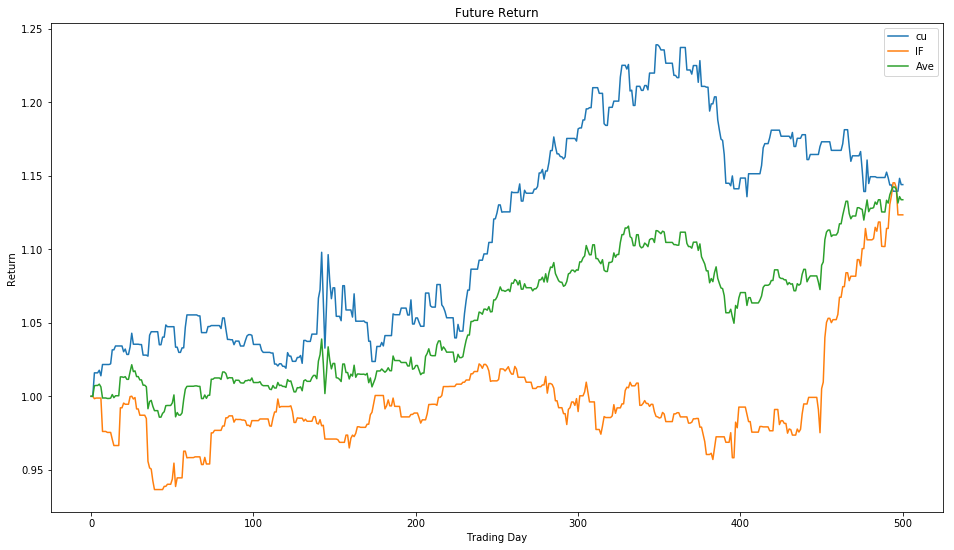

Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!


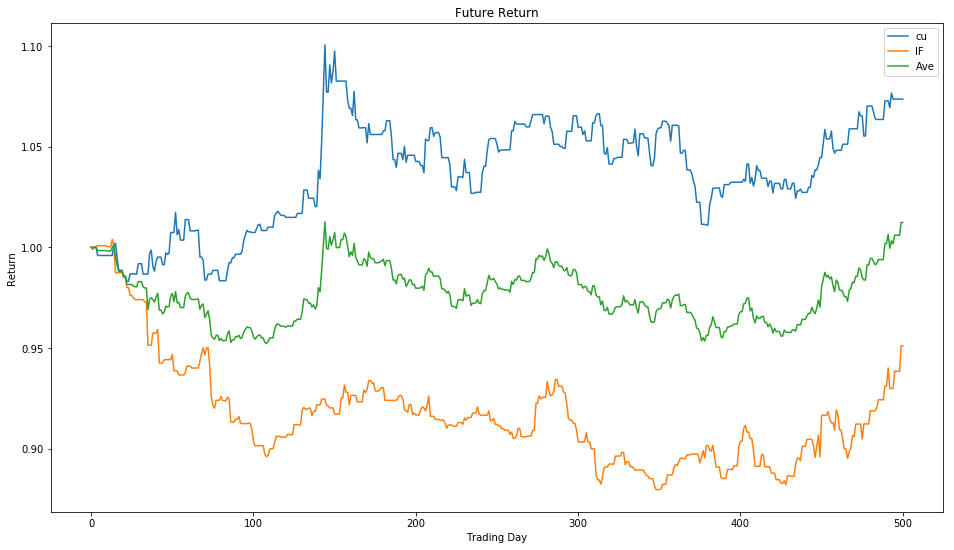

Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!


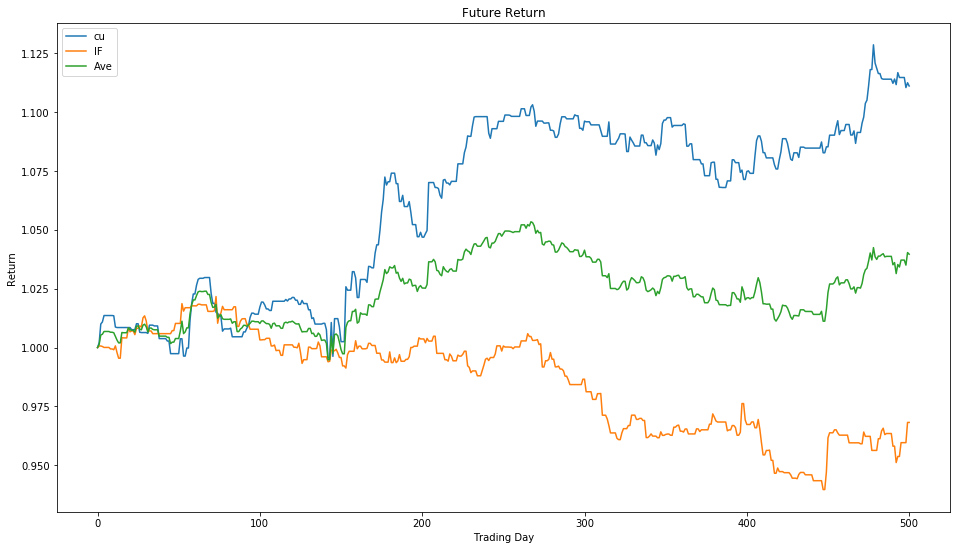

Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!


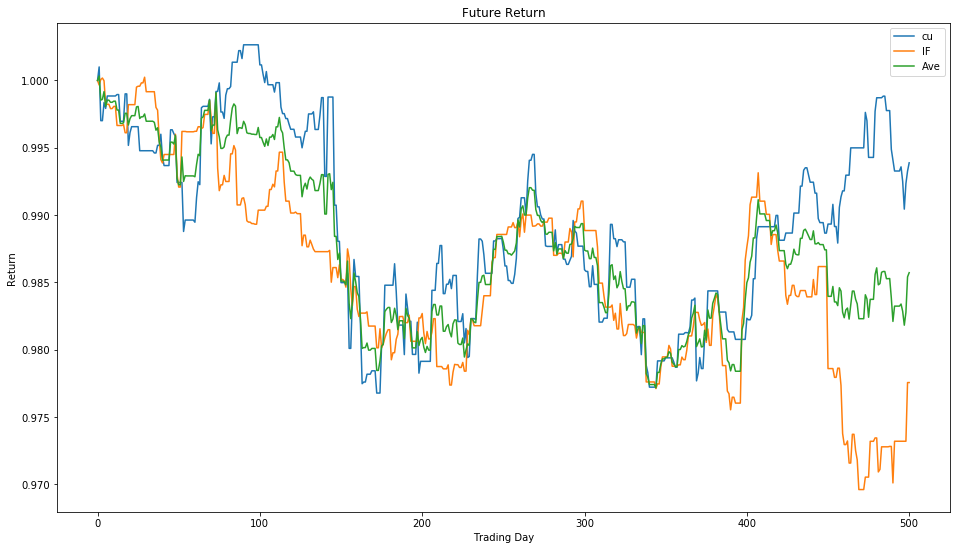

Bad State!
Bad State!
Bad State!


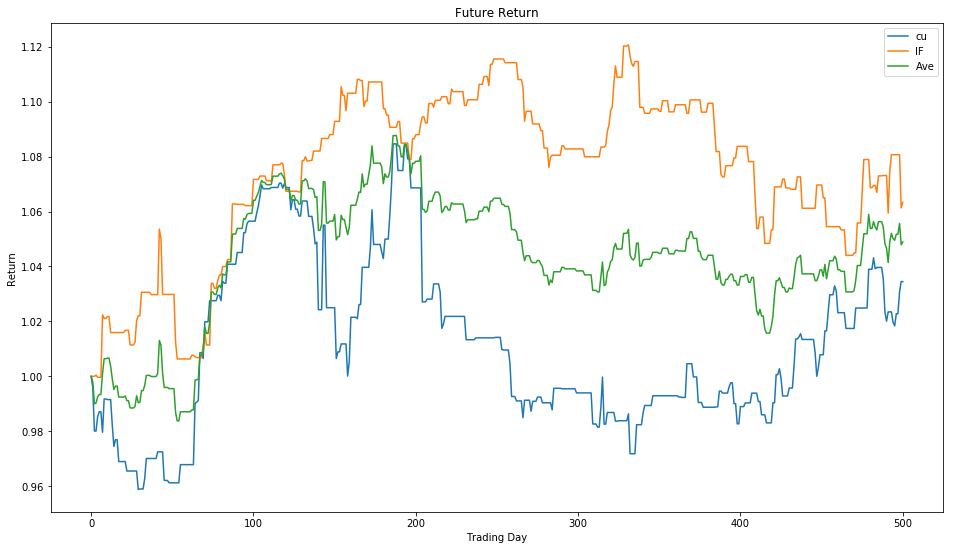

Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!


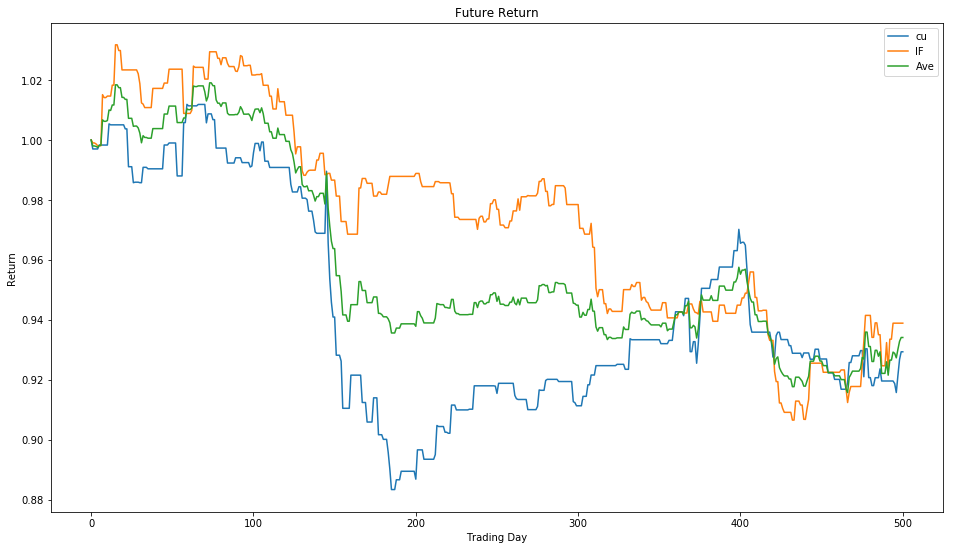

Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!


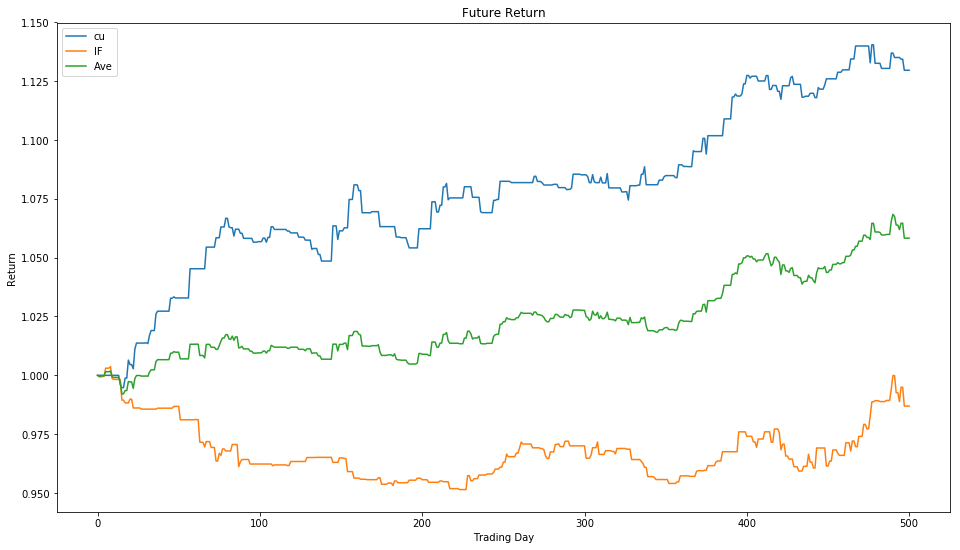

Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!


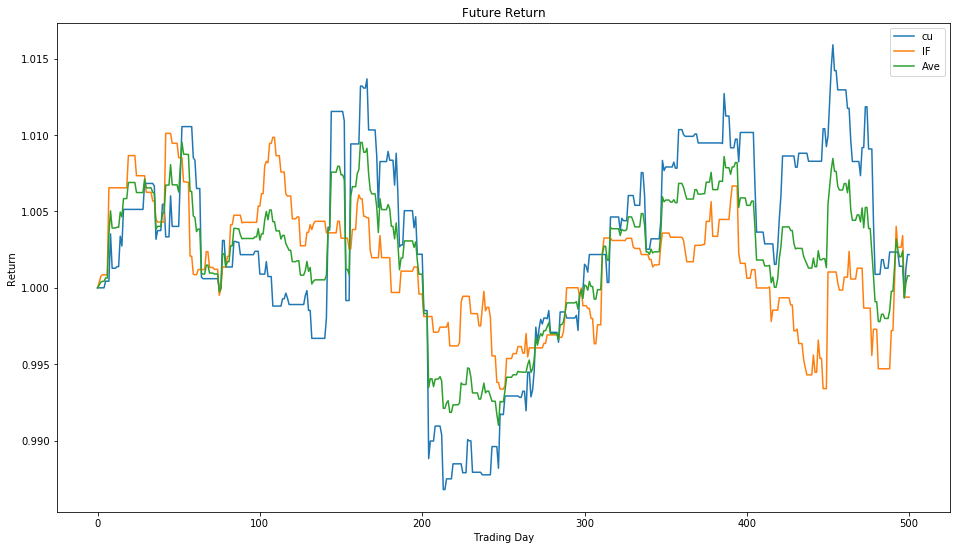

Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!


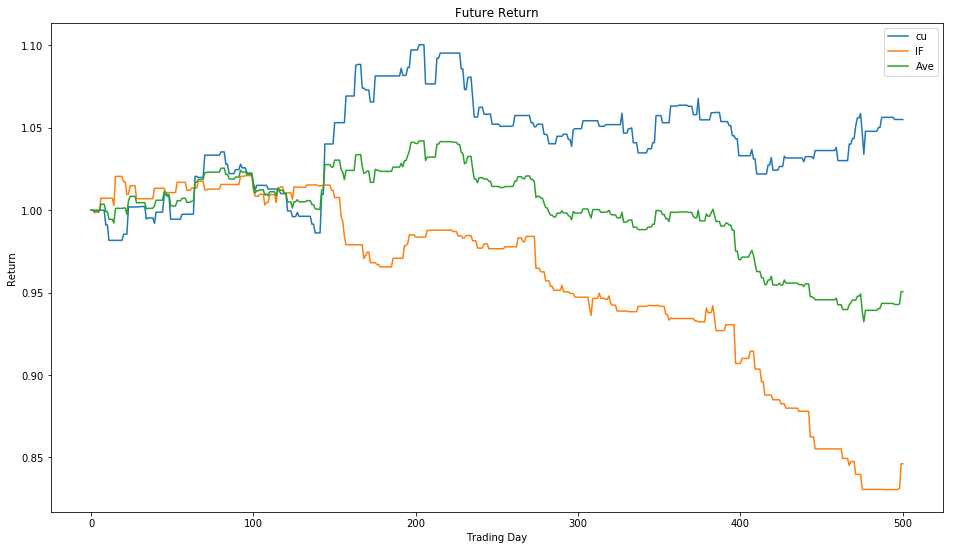

Bad State!
Bad State!


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


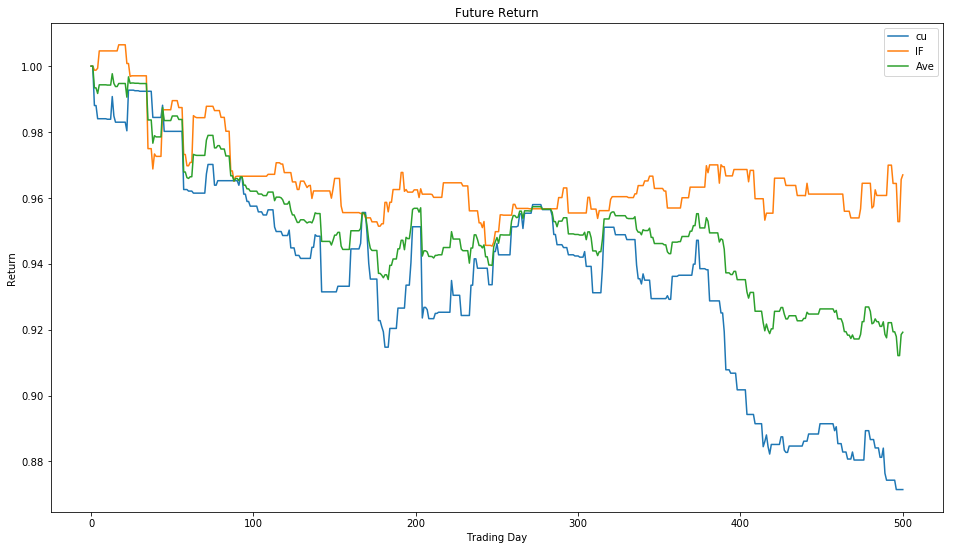

Bad State!
Bad State!
Bad State!
Bad State!


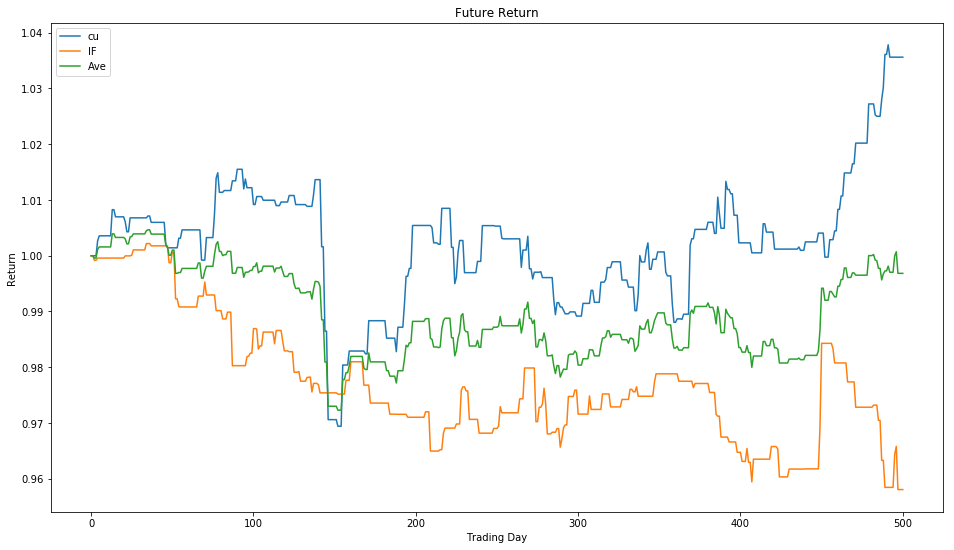

Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!
Bad State!


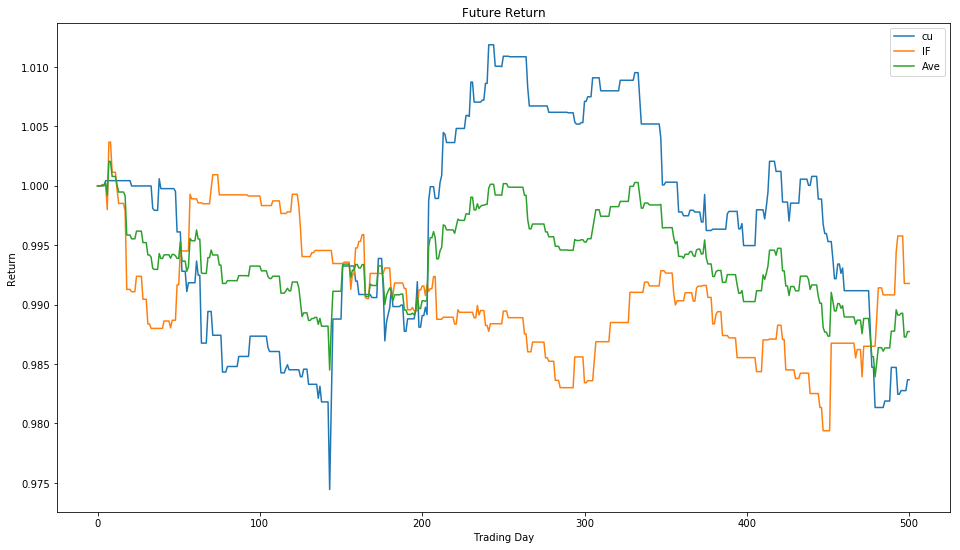

In [64]:
'''experiment(Columns = Columns, 
           FutureList = FutureList, 
           TestSize = TestSize, 
           PricePointNum = PricePointNum, 
           LabelNum = LabelNum, 
           HiddenStateNum = HiddenStateNum, 
           RankWeight = RankWeight, 
           PatternWeight = PatternWeight)'''

for price_point_num in PricePointNumRange:
    for label_num in LabelNumRange:
        for hidden_state_num in HiddenStateNumRange:
            for rank_weight in RankWeightRange:
                pattern_weight = 1.0 - rank_weight
                experiment(Columns = Columns, 
                           FutureList = FutureList, 
                           TestSize = TestSize, 
                           PricePointNum = price_point_num, 
                           LabelNum = label_num, 
                           HiddenStateNum = hidden_state_num, 
                           RankWeight = rank_weight, 
                           PatternWeight = pattern_weight)
